# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 09 Dec 2019

# Imports

In [1]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Reshape, Embedding, Dot
from tensorflow.keras.models import Model
sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

/home/omid/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import imp

def reload():
    imp.reload(utils)

# Parameters

In [3]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_with_only_first_influence.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
# data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data_roberta.pk'
test_fraction = 0.2
runs = 30

# Helper functions

In [4]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    elif type_str == 'cosine':
        err = sp.spatial.distance.cosine(
            np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        return err
    else:
        raise ValueError('Wrong type_str was given.')

In [5]:
def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
#     D = np.diag(np.array(np.sum(A, axis=0))[0])
#     L = D - A
#     return np.matrix(np.linalg.eig(L)[1])
    n, m = A.shape
    diags = A.sum(axis=1).flatten()
    D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
    L = D - A
    with sp.errstate(divide='ignore'):
        diags_sqrt = 1.0/sp.sqrt(diags)
    diags_sqrt[sp.isinf(diags_sqrt)] = 0
    DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    DH = DH.todense()
    normalized_L = DH.dot(L.dot(DH))
    return normalized_L

In [6]:
def my_init(shape, dtype=None):
    return np.ones(shape) * 0.25

# Loading the data

In [7]:
data = utils.load_it(data_fpath)
print(len(data['X']))

264


In [8]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'])

In [9]:
np.mean(mats, axis=0)

array([[0.25784649, 0.25013211, 0.25917224, 0.23284916],
       [0.21997335, 0.3244428 , 0.22187468, 0.23370918],
       [0.21050033, 0.25039752, 0.31083892, 0.22826324],
       [0.25180346, 0.23839655, 0.24293584, 0.26686416]])

In [10]:
np.std(mats, axis=0)

array([[0.11677549, 0.08129962, 0.08962429, 0.07536874],
       [0.08929333, 0.16587926, 0.08335618, 0.10916787],
       [0.08963767, 0.12213777, 0.16865608, 0.09193362],
       [0.09597464, 0.06509444, 0.05915974, 0.08748726]])

# Formulating the dual encoder mutli-tower model

In [19]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        X_train, y_train = utils.replicate_matrices_in_train_dataset_with_reordering(
            X_train, y_train)

        
        flatten_X_train_history = []
        flatten_X_train_text = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
            flatten_X_train_history.append(
                np.array(features['first_influence_matrices'].flatten())[0])
            flatten_X_train_text.append(
#                 features['individual_performance_hardness_weighted'])
                np.array(features['content_embedding_matrix'].flatten()))
#                 np.array(features['reply_duration'].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train_history = np.array(flatten_X_train_history)
        flatten_X_train_text = np.array(flatten_X_train_text)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test_history = []
        flatten_X_test_text = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']            
            flatten_X_test_history.append(
                np.array(features['first_influence_matrices'].flatten())[0])
            flatten_X_test_text.append(
#                 features['individual_performance_hardness_weighted'])
                np.array(features['content_embedding_matrix'].flatten()))
#                 np.array(features['reply_duration'].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test_history = np.array(flatten_X_test_history)
        flatten_X_test_text = np.array(flatten_X_test_text)
        flatten_y_test = np.array(flatten_y_test)


        # My model:
        first_influence_input = Input(shape=(16,), dtype='int32')
        text_input = Input(shape=(3072,), dtype='int32')
        encoder_history = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(64, kernel_initializer='he_normal', activation='relu'),
#             Dropout(0.5),
#             Dense(32, kernel_initializer='he_normal', activation='relu'),
#             Dropout(0.5),
            Dense(16, kernel_initializer='he_normal', activation='softmax')])
        encoder_text = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(64, kernel_initializer='he_normal', activation='relu'),
#             Dropout(0.5),
#             Dense(32, kernel_initializer='he_normal', activation='relu'),
#             Dropout(0.5),
            Dense(16, kernel_initializer='he_normal', activation='softmax')])
        #     Dense(16, kernel_initializer=my_init, activation='softmax')])
        history_answer = encoder_history(first_influence_input)
        text_answer = encoder_text(text_input)
        # Merge the layers with a dot product along the second axis 
        # (shape will be (None, 1, 1))
        merged = Concatenate(name='concat')([history_answer, text_answer])
        # Reshape to be a single number (shape will be (None, 1))
        merged = Reshape(target_shape = [32])(merged)
        # Squash outputs for classification
        out = Dense(16, kernel_initializer=my_init, activation = 'softmax')(merged)
        model = Model(inputs = [first_influence_input, text_input], outputs = out)
        # Compile using specified optimizer and loss 
        model.compile(optimizer='Adam',
                      loss='binary_crossentropy', 
                      metrics=['accuracy'])
        model.fit(
            x=[flatten_X_train_history, flatten_X_train_text],
            y=flatten_y_train,
            epochs=10,
            batch_size=16)
        predicted = model.predict(x=[flatten_X_test_history, flatten_X_test_text])



        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)
        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 5064 samples
Epoch 1/50
5064/5064 [==============================] - 1s 179us/sample - loss: 0.7405 - accuracy: 0.0116
Epoch 2/50
5064/5064 [==============================] - 0s 67us/sample - loss: 0.7395 - accuracy: 0.0116
Epoch 3/50
5064/5064 [==============================] - 0s 68us/sample - loss: 0.7384 - accuracy: 0.0116
Epoch 4/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7378 - accuracy: 0.0116
Epoch 5/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7373 - accuracy: 0.0116
Epoch 6/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7368 - accuracy: 0.0116
Epoch 7/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7365 - accuracy: 0.0116
Epoch 8/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7361 - accuracy: 0.0116
Epoch 9/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7359 - accuracy: 0.0116
Epoch 10/50
5064/5064 

5064/5064 [==============================] - 0s 76us/sample - loss: 0.7320 - accuracy: 0.0124
Epoch 28/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7318 - accuracy: 0.0124
Epoch 29/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7317 - accuracy: 0.0124
Epoch 30/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7315 - accuracy: 0.0124
Epoch 31/50
5064/5064 [==============================] - 0s 62us/sample - loss: 0.7314 - accuracy: 0.0124
Epoch 32/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7313 - accuracy: 0.0124
Epoch 33/50
5064/5064 [==============================] - 0s 65us/sample - loss: 0.7315 - accuracy: 0.0124
Epoch 34/50
5064/5064 [==============================] - 0s 64us/sample - loss: 0.7312 - accuracy: 0.0124
Epoch 35/50
5064/5064 [==============================] - 0s 67us/sample - loss: 0.7312 - accuracy: 0.0124
Epoch 36/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 70us/sample - loss: 0.7386 - accuracy: 0.0110
Epoch 4/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7379 - accuracy: 0.0110
Epoch 5/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7376 - accuracy: 0.0110
Epoch 6/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7373 - accuracy: 0.0110
Epoch 7/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7371 - accuracy: 0.0110
Epoch 8/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7369 - accuracy: 0.0110
Epoch 9/50
5064/5064 [==============================] - 0s 63us/sample - loss: 0.7367 - accuracy: 0.0110
Epoch 10/50
5064/5064 [==============================] - 0s 65us/sample - loss: 0.7366 - accuracy: 0.0110
Epoch 11/50
5064/5064 [==============================] - 0s 64us/sample - loss: 0.7364 - accuracy: 0.0110
Epoch 12/50
5064/5064 [==============================] - 0s 71us

5064/5064 [==============================] - 0s 71us/sample - loss: 0.7320 - accuracy: 0.0124
Epoch 31/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7318 - accuracy: 0.0124
Epoch 32/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7317 - accuracy: 0.0124
Epoch 33/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7315 - accuracy: 0.0124
Epoch 34/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7315 - accuracy: 0.0124
Epoch 35/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7314 - accuracy: 0.0124
Epoch 36/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7312 - accuracy: 0.0124
Epoch 37/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7314 - accuracy: 0.0124
Epoch 38/50
5064/5064 [==============================] - 0s 68us/sample - loss: 0.7312 - accuracy: 0.0124
Epoch 39/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 71us/sample - loss: 0.7370 - accuracy: 0.0118
Epoch 7/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7367 - accuracy: 0.0118
Epoch 8/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7364 - accuracy: 0.0118
Epoch 9/50
5064/5064 [==============================] - 0s 65us/sample - loss: 0.7360 - accuracy: 0.0118
Epoch 10/50
5064/5064 [==============================] - 0s 64us/sample - loss: 0.7357 - accuracy: 0.0118
Epoch 11/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7353 - accuracy: 0.0118
Epoch 12/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7350 - accuracy: 0.0118
Epoch 13/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7347 - accuracy: 0.0118
Epoch 14/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7343 - accuracy: 0.0118
Epoch 15/50
5064/5064 [==============================] - 0s 7

5064/5064 [==============================] - 0s 71us/sample - loss: 0.7315 - accuracy: 0.0118
Epoch 34/50
5064/5064 [==============================] - 0s 64us/sample - loss: 0.7314 - accuracy: 0.0118
Epoch 35/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7312 - accuracy: 0.0118
Epoch 36/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7311 - accuracy: 0.0118
Epoch 37/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7311 - accuracy: 0.0118
Epoch 38/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7310 - accuracy: 0.0118
Epoch 39/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7308 - accuracy: 0.0118
Epoch 40/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7307 - accuracy: 0.0118
Epoch 41/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7307 - accuracy: 0.0118
Epoch 42/50
5064/5064 [==============================] - 0

Epoch 10/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7357 - accuracy: 0.0110
Epoch 11/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7354 - accuracy: 0.0110
Epoch 12/50
5064/5064 [==============================] - 0s 67us/sample - loss: 0.7353 - accuracy: 0.0110
Epoch 13/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7351 - accuracy: 0.0110
Epoch 14/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7349 - accuracy: 0.0110
Epoch 15/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7348 - accuracy: 0.0110
Epoch 16/50
5064/5064 [==============================] - 0s 63us/sample - loss: 0.7347 - accuracy: 0.0110
Epoch 17/50
5064/5064 [==============================] - 0s 68us/sample - loss: 0.7346 - accuracy: 0.0110
Epoch 18/50
5064/5064 [==============================] - 0s 64us/sample - loss: 0.7344 - accuracy: 0.0110
Epoch 19/50
5064/5064 [=======================

5064/5064 [==============================] - 0s 70us/sample - loss: 0.7318 - accuracy: 0.0118
Epoch 38/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7319 - accuracy: 0.0118
Epoch 39/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7317 - accuracy: 0.0118
Epoch 40/50
5064/5064 [==============================] - 0s 63us/sample - loss: 0.7317 - accuracy: 0.0118
Epoch 41/50
5064/5064 [==============================] - 0s 63us/sample - loss: 0.7317 - accuracy: 0.0118
Epoch 42/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7314 - accuracy: 0.0118
Epoch 43/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7316 - accuracy: 0.0118
Epoch 44/50
5064/5064 [==============================] - 0s 63us/sample - loss: 0.7315 - accuracy: 0.0118
Epoch 45/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7313 - accuracy: 0.0118
Epoch 46/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 74us/sample - loss: 0.7343 - accuracy: 0.0145
Epoch 14/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7340 - accuracy: 0.0145
Epoch 15/50
5064/5064 [==============================] - 0s 78us/sample - loss: 0.7339 - accuracy: 0.0145
Epoch 16/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7338 - accuracy: 0.0145
Epoch 17/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7337 - accuracy: 0.0145
Epoch 18/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7334 - accuracy: 0.0145
Epoch 19/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7333 - accuracy: 0.0145
Epoch 20/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7330 - accuracy: 0.0145
Epoch 21/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7328 - accuracy: 0.0145
Epoch 22/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 79us/sample - loss: 0.7310 - accuracy: 0.0118
Epoch 41/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7311 - accuracy: 0.0118
Epoch 42/50
5064/5064 [==============================] - 0s 78us/sample - loss: 0.7310 - accuracy: 0.0118
Epoch 43/50
5064/5064 [==============================] - 0s 87us/sample - loss: 0.7309 - accuracy: 0.0118
Epoch 44/50
5064/5064 [==============================] - 0s 90us/sample - loss: 0.7309 - accuracy: 0.0118
Epoch 45/50
5064/5064 [==============================] - 0s 87us/sample - loss: 0.7310 - accuracy: 0.0118
Epoch 46/50
5064/5064 [==============================] - 0s 80us/sample - loss: 0.7309 - accuracy: 0.0118
Epoch 47/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7308 - accuracy: 0.0118
Epoch 48/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7307 - accuracy: 0.0118
Epoch 49/50
5064/5064 [==============================] - 0

Epoch 17/50
5064/5064 [==============================] - 0s 78us/sample - loss: 0.7346 - accuracy: 0.0101
Epoch 18/50
5064/5064 [==============================] - 0s 89us/sample - loss: 0.7344 - accuracy: 0.0101
Epoch 19/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7344 - accuracy: 0.0101
Epoch 20/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7344 - accuracy: 0.0101
Epoch 21/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7342 - accuracy: 0.0101
Epoch 22/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7340 - accuracy: 0.0101
Epoch 23/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7340 - accuracy: 0.0101
Epoch 24/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7338 - accuracy: 0.0101
Epoch 25/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7337 - accuracy: 0.0101
Epoch 26/50
5064/5064 [=======================

5064/5064 [==============================] - 0s 80us/sample - loss: 0.7311 - accuracy: 0.0098
Epoch 45/50
5064/5064 [==============================] - 0s 80us/sample - loss: 0.7310 - accuracy: 0.0098
Epoch 46/50
5064/5064 [==============================] - 0s 83us/sample - loss: 0.7310 - accuracy: 0.0098
Epoch 47/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7311 - accuracy: 0.0098
Epoch 48/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7310 - accuracy: 0.0098
Epoch 49/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7309 - accuracy: 0.0098
Epoch 50/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7310 - accuracy: 0.0098
Run 17 ...
Train on 5064 samples
Epoch 1/50
5064/5064 [==============================] - 1s 176us/sample - loss: 0.7406 - accuracy: 0.0113
Epoch 2/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7397 - accuracy: 0.0113
Epoch 3/50
5064/5064 [====

Epoch 21/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7343 - accuracy: 0.0133
Epoch 22/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7340 - accuracy: 0.0133
Epoch 23/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7338 - accuracy: 0.0133
Epoch 24/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7335 - accuracy: 0.0133
Epoch 25/50
5064/5064 [==============================] - 0s 88us/sample - loss: 0.7335 - accuracy: 0.0133
Epoch 26/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7331 - accuracy: 0.0133
Epoch 27/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7330 - accuracy: 0.0133
Epoch 28/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7328 - accuracy: 0.0133
Epoch 29/50
5064/5064 [==============================] - 0s 80us/sample - loss: 0.7326 - accuracy: 0.0133
Epoch 30/50
5064/5064 [=======================

5064/5064 [==============================] - 0s 80us/sample - loss: 0.7318 - accuracy: 0.0101
Epoch 49/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7316 - accuracy: 0.0101
Epoch 50/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7316 - accuracy: 0.0101
Run 20 ...
Train on 5064 samples
Epoch 1/50
5064/5064 [==============================] - 1s 290us/sample - loss: 0.7404 - accuracy: 0.0118
Epoch 2/50
5064/5064 [==============================] - 0s 68us/sample - loss: 0.7395 - accuracy: 0.0118
Epoch 3/50
5064/5064 [==============================] - 0s 86us/sample - loss: 0.7383 - accuracy: 0.0118
Epoch 4/50
5064/5064 [==============================] - 0s 83us/sample - loss: 0.7375 - accuracy: 0.0118
Epoch 5/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7371 - accuracy: 0.0118
Epoch 6/50
5064/5064 [==============================] - 0s 78us/sample - loss: 0.7367 - accuracy: 0.0118
Epoch 7/50
5064/5064 [========

Epoch 25/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7331 - accuracy: 0.0113
Epoch 26/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7330 - accuracy: 0.0113
Epoch 27/50
5064/5064 [==============================] - 0s 78us/sample - loss: 0.7330 - accuracy: 0.0113
Epoch 28/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7327 - accuracy: 0.0113
Epoch 29/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7327 - accuracy: 0.0113
Epoch 30/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7325 - accuracy: 0.0113
Epoch 31/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7324 - accuracy: 0.0113
Epoch 32/50
5064/5064 [==============================] - 0s 65us/sample - loss: 0.7322 - accuracy: 0.0113
Epoch 33/50
5064/5064 [==============================] - 0s 62us/sample - loss: 0.7322 - accuracy: 0.0113
Epoch 34/50
5064/5064 [=======================

5064/5064 [==============================] - 1s 201us/sample - loss: 0.7404 - accuracy: 0.0110
Epoch 2/50
5064/5064 [==============================] - 0s 80us/sample - loss: 0.7397 - accuracy: 0.0110
Epoch 3/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7387 - accuracy: 0.0110
Epoch 4/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7378 - accuracy: 0.0110
Epoch 5/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7372 - accuracy: 0.0110
Epoch 6/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7369 - accuracy: 0.0110
Epoch 7/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7365 - accuracy: 0.0110
Epoch 8/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7363 - accuracy: 0.0110
Epoch 9/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7360 - accuracy: 0.0110
Epoch 10/50
5064/5064 [==============================] - 0s 75us/

5064/5064 [==============================] - 0s 76us/sample - loss: 0.7327 - accuracy: 0.0130
Epoch 29/50
5064/5064 [==============================] - 0s 84us/sample - loss: 0.7324 - accuracy: 0.0130
Epoch 30/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7322 - accuracy: 0.0130
Epoch 31/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7320 - accuracy: 0.0130
Epoch 32/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7317 - accuracy: 0.0130
Epoch 33/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7315 - accuracy: 0.0130
Epoch 34/50
5064/5064 [==============================] - 0s 66us/sample - loss: 0.7312 - accuracy: 0.0130
Epoch 35/50
5064/5064 [==============================] - 0s 71us/sample - loss: 0.7312 - accuracy: 0.0130
Epoch 36/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7312 - accuracy: 0.0130
Epoch 37/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 75us/sample - loss: 0.7381 - accuracy: 0.0110
Epoch 5/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7378 - accuracy: 0.0110
Epoch 6/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7376 - accuracy: 0.0110
Epoch 7/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7374 - accuracy: 0.0110
Epoch 8/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7372 - accuracy: 0.0110
Epoch 9/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7369 - accuracy: 0.0110
Epoch 10/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7365 - accuracy: 0.0110
Epoch 11/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7361 - accuracy: 0.0110
Epoch 12/50
5064/5064 [==============================] - 0s 79us/sample - loss: 0.7358 - accuracy: 0.0110
Epoch 13/50
5064/5064 [==============================] - 0s 80u

5064/5064 [==============================] - 0s 83us/sample - loss: 0.7328 - accuracy: 0.0104
Epoch 32/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7328 - accuracy: 0.0104
Epoch 33/50
5064/5064 [==============================] - 0s 81us/sample - loss: 0.7325 - accuracy: 0.0104
Epoch 34/50
5064/5064 [==============================] - 0s 84us/sample - loss: 0.7326 - accuracy: 0.0104
Epoch 35/50
5064/5064 [==============================] - 0s 69us/sample - loss: 0.7324 - accuracy: 0.0104
Epoch 36/50
5064/5064 [==============================] - 0s 77us/sample - loss: 0.7324 - accuracy: 0.0104
Epoch 37/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7324 - accuracy: 0.0104
Epoch 38/50
5064/5064 [==============================] - 0s 70us/sample - loss: 0.7322 - accuracy: 0.0104
Epoch 39/50
5064/5064 [==============================] - 0s 73us/sample - loss: 0.7321 - accuracy: 0.0104
Epoch 40/50
5064/5064 [==============================] - 0

5064/5064 [==============================] - 0s 73us/sample - loss: 0.7366 - accuracy: 0.0133
Epoch 8/50
5064/5064 [==============================] - 0s 86us/sample - loss: 0.7364 - accuracy: 0.0133
Epoch 9/50
5064/5064 [==============================] - 0s 94us/sample - loss: 0.7362 - accuracy: 0.0133
Epoch 10/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7360 - accuracy: 0.0133
Epoch 11/50
5064/5064 [==============================] - 0s 72us/sample - loss: 0.7358 - accuracy: 0.0133
Epoch 12/50
5064/5064 [==============================] - 0s 76us/sample - loss: 0.7356 - accuracy: 0.0133
Epoch 13/50
5064/5064 [==============================] - 0s 85us/sample - loss: 0.7353 - accuracy: 0.0133
Epoch 14/50
5064/5064 [==============================] - 0s 75us/sample - loss: 0.7350 - accuracy: 0.0133
Epoch 15/50
5064/5064 [==============================] - 0s 74us/sample - loss: 0.7348 - accuracy: 0.0133
Epoch 16/50
5064/5064 [==============================] - 0s 

random: 0.6245057354619394 +- 0.01950503609724527
uniform: 0.33205255804424066 +- 0.021224554926643796
model: 0.36301795393594344 +- 0.024604014999325227


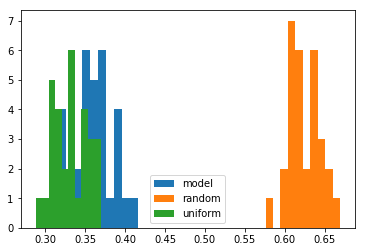

In [20]:
plt.hist(model_errs)
plt.hist(random_errs)
plt.hist(uniform_errs)
plt.legend(['model', 'random', 'uniform']);

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# Formulating the neural network model with concatinated inputs

## Only content embeddings

In [76]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)
        
#         mats = []
#         for i in range(len(y_train)):
#             mats.append(y_train[i]['influence_matrix'])
#         average_matrix = np.mean(mats, axis=0)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
#             flatten_X_train.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_train.append(features['content_embedding_matrix'].flatten())
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
#             flatten_X_test.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_test.append(features['content_embedding_matrix'].flatten())
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3072,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(16, kernel_initializer='he_normal', activation='softmax')])
            Dense(16, kernel_initializer=my_init, activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7396 - accuracy: 0.0188
Epoch 2/10
269/269 [==============================] - 0s 106us/sample - loss: 0.7387 - accuracy: 0.0188
Epoch 3/10
269/269 [==============================] - 0s 107us/sample - loss: 0.7385 - accuracy: 0.0188
Epoch 4/10
269/269 [==============================] - 0s 97us/sample - loss: 0.7382 - accuracy: 0.0188
Epoch 5/10
269/269 [==============================] - 0s 91us/sample - loss: 0.7379 - accuracy: 0.0188
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7377 - accuracy: 0.0188
Epoch 7/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7372 - accuracy: 0.0188
Epoch 8/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7373 - accuracy: 0.0188
Epoch 9/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7364 - accuracy: 0.0188
Epoch 10/10
269/269 [====================

269/269 [==============================] - 0s 67us/sample - loss: 0.7372 - accuracy: 0.0179
Epoch 9/10
269/269 [==============================] - 0s 67us/sample - loss: 0.7368 - accuracy: 0.0179
Epoch 10/10
269/269 [==============================] - 0s 70us/sample - loss: 0.7370 - accuracy: 0.0179
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7389 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 0.7381 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 96us/sample - loss: 0.7379 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7373 - accuracy: 0.0167
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7372 - accuracy: 0.0167
Epoch 6/10
269/269 [==============================] - 0s 87us/sample - loss: 0.7369 - accuracy: 0.0167
Epoch 7/10
269/269 [==============================] -

269/269 [==============================] - 0s 96us/sample - loss: 0.7365 - accuracy: 0.0193
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7362 - accuracy: 0.0193
Epoch 7/10
269/269 [==============================] - 0s 76us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 8/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 0.7356 - accuracy: 0.0193
Epoch 10/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7361 - accuracy: 0.0193
Run 16 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7391 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7385 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 83us/sample - loss: 0.7384 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] 

random: 0.6358637687891749 +- 0.017407726721425588
uniform: 0.3522141490130312 +- 0.018461737356623154
model: 0.34663943089383537 +- 0.016315834977931095


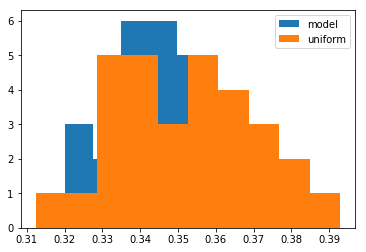

In [77]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## Only networks

In [15]:
all_networks = True
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 80
lambda1 = 1

In [16]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim,),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=64,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)
        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1129.2028 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 110us/sample - loss: 1064.8313 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 91us/sample - loss: 1003.3088 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 71us/sample - loss: 944.0386 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 888.0018 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 76us/sample - loss: 834.2492 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 75us/sample - loss: 782.8130 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 733.7862 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 69us/sample - loss: 686.8196 - accuracy: 0.0181
Epoch 10/10
269/269 [

269/269 [==============================] - 1s 3ms/sample - loss: 1135.1535 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 1071.0275 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 88us/sample - loss: 1008.8973 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 79us/sample - loss: 949.9622 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 68us/sample - loss: 892.7380 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 73us/sample - loss: 838.4916 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 65us/sample - loss: 786.4447 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 736.9422 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 62us/sample - loss: 689.7770 - accuracy: 0.0181
Epoch 10/10
269/269 [==============================] - 0s 65us/s

random: 0.6310301214868926 +- 0.01399059267030896
uniform: 0.34745737869634064 +- 0.017530337002096035
model: 0.34513695020571783 +- 0.016975889090539077


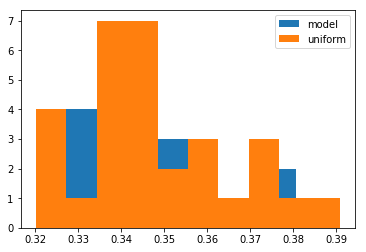

In [17]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# with Convolutional layers

In [84]:
all_networks = All
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 16
lambda1 = 1

In [85]:
with Timer():
    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(
            np.reshape(flatten_X_train, (len(flatten_X_train), input_dim, 1)),
            flatten_y_train,
            epochs=10,
            batch_size=64)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), input_dim, 1)))

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 4ms/sample - loss: 2328.1521 - accuracy: 0.0137
Epoch 2/10
247/247 [==============================] - 0s 80us/sample - loss: 2224.8803 - accuracy: 0.0137
Epoch 3/10
247/247 [==============================] - 0s 74us/sample - loss: 2136.6592 - accuracy: 0.0137
Epoch 4/10
247/247 [==============================] - 0s 75us/sample - loss: 2058.9072 - accuracy: 0.0137
Epoch 5/10
247/247 [==============================] - 0s 71us/sample - loss: 1987.1194 - accuracy: 0.0137
Epoch 6/10
247/247 [==============================] - 0s 65us/sample - loss: 1920.5766 - accuracy: 0.0137
Epoch 7/10
247/247 [==============================] - 0s 67us/sample - loss: 1857.6044 - accuracy: 0.0137
Epoch 8/10
247/247 [==============================] - 0s 74us/sample - loss: 1797.3332 - accuracy: 0.0137
Epoch 9/10
247/247 [==============================] - 0s 61us/sample - loss: 1739.3273 - accuracy: 0.0137
Epoch 10/10
247/

Epoch 6/10
247/247 [==============================] - 0s 72us/sample - loss: 1961.0035 - accuracy: 0.0154
Epoch 7/10
247/247 [==============================] - 0s 66us/sample - loss: 1894.9165 - accuracy: 0.0154
Epoch 8/10
247/247 [==============================] - 0s 66us/sample - loss: 1833.2831 - accuracy: 0.0154
Epoch 9/10
247/247 [==============================] - 0s 68us/sample - loss: 1774.7719 - accuracy: 0.0154
Epoch 10/10
247/247 [==============================] - 0s 67us/sample - loss: 1718.7325 - accuracy: 0.0154
Run 8 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 4ms/sample - loss: 2450.9738 - accuracy: 0.0170
Epoch 2/10
247/247 [==============================] - 0s 99us/sample - loss: 2326.1657 - accuracy: 0.0170
Epoch 3/10
247/247 [==============================] - 0s 95us/sample - loss: 2222.3188 - accuracy: 0.0170
Epoch 4/10
247/247 [==============================] - 0s 87us/sample - loss: 2133.2157 - accuracy: 0.0170
Epoch 5/10
247/

247/247 [==============================] - 1s 4ms/sample - loss: 2395.9479 - accuracy: 0.0159
Epoch 2/10
247/247 [==============================] - 0s 84us/sample - loss: 2277.8744 - accuracy: 0.0159
Epoch 3/10
247/247 [==============================] - 0s 83us/sample - loss: 2180.1931 - accuracy: 0.0159
Epoch 4/10
247/247 [==============================] - 0s 74us/sample - loss: 2095.2252 - accuracy: 0.0159
Epoch 5/10
247/247 [==============================] - 0s 66us/sample - loss: 2019.9586 - accuracy: 0.0159
Epoch 6/10
247/247 [==============================] - 0s 61us/sample - loss: 1951.9185 - accuracy: 0.0159
Epoch 7/10
247/247 [==============================] - 0s 58us/sample - loss: 1888.6318 - accuracy: 0.0159
Epoch 8/10
247/247 [==============================] - 0s 56us/sample - loss: 1828.6732 - accuracy: 0.0159
Epoch 9/10
247/247 [==============================] - 0s 55us/sample - loss: 1771.7502 - accuracy: 0.0159
Epoch 10/10
247/247 [==============================] - 0s 

random: 0.6260289081160294 +- 0.019073459226181894
uniform: 0.33818010164865875 +- 0.020875331206619
model: 0.3375603516034832 +- 0.021005153522982288


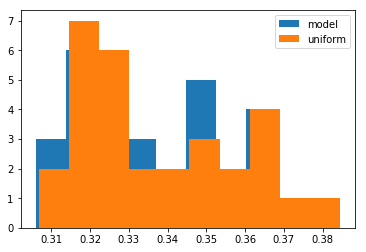

In [86]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# All together

In [16]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
            flatten_X_train.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            flatten_X_test.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3152,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(16, kernel_initializer='he_normal', activation='softmax')])
            Dense(16, kernel_initializer=my_init, activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
247/247 [==============================] - 1s 3ms/sample - loss: 0.7408 - accuracy: 0.0154
Epoch 2/10
247/247 [==============================] - 0s 139us/sample - loss: 0.7402 - accuracy: 0.0154
Epoch 3/10
247/247 [==============================] - 0s 104us/sample - loss: 0.7396 - accuracy: 0.0154
Epoch 4/10
247/247 [==============================] - 0s 99us/sample - loss: 0.7396 - accuracy: 0.0154
Epoch 5/10
247/247 [==============================] - 0s 101us/sample - loss: 0.7390 - accuracy: 0.0154
Epoch 6/10
247/247 [==============================] - 0s 87us/sample - loss: 0.7390 - accuracy: 0.0154
Epoch 7/10
247/247 [==============================] - 0s 86us/sample - loss: 0.7389 - accuracy: 0.0154
Epoch 8/10
247/247 [==============================] - 0s 84us/sample - loss: 0.7385 - accuracy: 0.0154
Epoch 9/10
247/247 [=============================

247/247 [==============================] - 0s 85us/sample - loss: 0.7396 - accuracy: 0.0149
Epoch 6/10
247/247 [==============================] - 0s 99us/sample - loss: 0.7391 - accuracy: 0.0149
Epoch 7/10
247/247 [==============================] - 0s 87us/sample - loss: 0.7389 - accuracy: 0.0149
Epoch 8/10
247/247 [==============================] - 0s 83us/sample - loss: 0.7384 - accuracy: 0.0149
Epoch 9/10
247/247 [==============================] - 0s 81us/sample - loss: 0.7384 - accuracy: 0.0149
Epoch 10/10
247/247 [==============================] - 0s 82us/sample - loss: 0.7382 - accuracy: 0.0149
Run 8 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================] - 1s 2ms/sample - loss: 0.7409 - accuracy: 0.0142
Epoch 2/10
247/247 [==============================] - 0s 93us/sample - loss: 0.7400 - accuracy: 0.0142
Epoch 3/10
247/247 [==============================] - 0s 98us/sample - loss: 0.7397 - accuracy: 0.0142
Epoch 4/10
247/247 [==============================] -

247/247 [==============================] - 0s 91us/sample - loss: 0.7401 - accuracy: 0.0182
Epoch 3/10
247/247 [==============================] - 0s 74us/sample - loss: 0.7398 - accuracy: 0.0182
Epoch 4/10
247/247 [==============================] - 0s 83us/sample - loss: 0.7392 - accuracy: 0.0182
Epoch 5/10
247/247 [==============================] - 0s 78us/sample - loss: 0.7393 - accuracy: 0.0182
Epoch 6/10
247/247 [==============================] - 0s 80us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 7/10
247/247 [==============================] - 0s 82us/sample - loss: 0.7389 - accuracy: 0.0182
Epoch 8/10
247/247 [==============================] - 0s 78us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 9/10
247/247 [==============================] - 0s 85us/sample - loss: 0.7385 - accuracy: 0.0182
Epoch 10/10
247/247 [==============================] - 0s 74us/sample - loss: 0.7383 - accuracy: 0.0182
Run 16 ...
Train on 247 samples
Epoch 1/10
247/247 [==============================]

random: 0.629000514749951 +- 0.01566901726757875
uniform: 0.3434295278358921 +- 0.02040265156790686
model: 0.33717033132955276 +- 0.020186327022324663


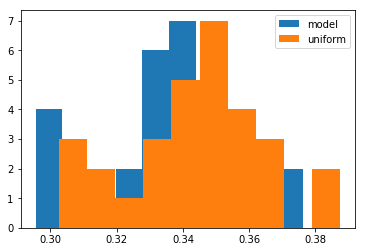

In [17]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# All with convolutional layers

In [113]:
import keras.backend as K

def my_metric(y_true, y_pred):
#     return K.mean(y_pred)
    return K.square(y_true - y_pred)

In [133]:
runs = 1

In [138]:
with Timer():
    
    input_dim = 3152

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
            flatten_X_train.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_train.append(np.array(label.flatten())[0])
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            flatten_X_test.append(np.hstack(
                [features['content_embedding_matrix'].flatten(),
                 np.array(features['reply_duration'].flatten())[0],
                 np.array(features['sentiment'].flatten())[0],
                 np.array(features['emotion_arousal'].flatten())[0],
                 np.array(features['emotion_dominance'].flatten())[0],
                 np.array(features['emotion_valence'].flatten())[0]]))
            flatten_y_test.append(np.array(label.flatten())[0])
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        
    
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['mae'])
        model.fit(
            np.reshape(flatten_X_train, (len(flatten_X_train), input_dim, 1)),
            flatten_y_train,
            epochs=5000,
            batch_size=64)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), input_dim, 1)))

    

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix']

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 247 samples
Epoch 1/5000
247/247 [==============================] - 3s 11ms/sample - loss: 130784.1926 - mae: 0.2001
Epoch 2/5000
247/247 [==============================] - 1s 3ms/sample - loss: 104463.6982 - mae: 0.1930
Epoch 3/5000
247/247 [==============================] - 1s 3ms/sample - loss: 86109.6613 - mae: 0.1904
Epoch 4/5000
247/247 [==============================] - 1s 3ms/sample - loss: 73238.5677 - mae: 0.1900
Epoch 5/5000
247/247 [==============================] - 1s 3ms/sample - loss: 64018.5340 - mae: 0.1899
Epoch 6/5000
247/247 [==============================] - 1s 3ms/sample - loss: 57178.7794 - mae: 0.1898
Epoch 7/5000
247/247 [==============================] - 1s 3ms/sample - loss: 51933.1706 - mae: 0.1898
Epoch 8/5000
247/247 [==============================] - 1s 3ms/sample - loss: 47813.7147 - mae: 0.1898
Epoch 9/5000
247/247 [==============================] - 1s 3ms/sample - loss: 44512.1097 - mae: 0.1898
Epoch 10/5000
247/247 [================

247/247 [==============================] - 1s 3ms/sample - loss: 7239.8150 - mae: 0.1897
Epoch 158/5000
247/247 [==============================] - 1s 3ms/sample - loss: 7182.1112 - mae: 0.1897
Epoch 159/5000
247/247 [==============================] - 1s 3ms/sample - loss: 7124.9624 - mae: 0.1897
Epoch 160/5000
247/247 [==============================] - 1s 3ms/sample - loss: 7068.2691 - mae: 0.1897
Epoch 161/5000
247/247 [==============================] - 1s 3ms/sample - loss: 7012.0856 - mae: 0.1897
Epoch 162/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6956.3822 - mae: 0.1897
Epoch 163/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6901.0772 - mae: 0.1897
Epoch 164/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6846.3133 - mae: 0.1897
Epoch 165/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6791.9484 - mae: 0.1897
Epoch 166/5000
247/247 [==============================] - 1s 3ms/sample - loss:

247/247 [==============================] - 1s 3ms/sample - loss: 2184.8809 - mae: 0.1897
Epoch 314/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2169.6924 - mae: 0.1897
Epoch 315/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2154.6131 - mae: 0.1897
Epoch 316/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2139.6878 - mae: 0.1897
Epoch 317/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2124.9044 - mae: 0.1897
Epoch 318/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2110.2373 - mae: 0.1897
Epoch 319/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2095.6988 - mae: 0.1897
Epoch 320/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2081.3072 - mae: 0.1897
Epoch 321/5000
247/247 [==============================] - 1s 3ms/sample - loss: 2067.0746 - mae: 0.1897
Epoch 322/5000
247/247 [==============================] - 1s 3ms/sample - loss:

247/247 [==============================] - 1s 3ms/sample - loss: 908.2588 - mae: 0.1897
Epoch 471/5000
247/247 [==============================] - 1s 3ms/sample - loss: 904.4739 - mae: 0.1897
Epoch 472/5000
247/247 [==============================] - 1s 3ms/sample - loss: 900.7210 - mae: 0.1897
Epoch 473/5000
247/247 [==============================] - 1s 3ms/sample - loss: 896.9848 - mae: 0.1897
Epoch 474/5000
247/247 [==============================] - 1s 3ms/sample - loss: 893.2853 - mae: 0.1897
Epoch 475/5000
247/247 [==============================] - 1s 3ms/sample - loss: 889.6143 - mae: 0.1897
Epoch 476/5000
247/247 [==============================] - 1s 3ms/sample - loss: 885.9791 - mae: 0.1897
Epoch 477/5000
247/247 [==============================] - 1s 3ms/sample - loss: 882.3699 - mae: 0.1897
Epoch 478/5000
247/247 [==============================] - 1s 3ms/sample - loss: 878.7816 - mae: 0.1897
Epoch 479/5000
247/247 [==============================] - 1s 3ms/sample - loss: 875.2408

247/247 [==============================] - 1s 3ms/sample - loss: 542.0814 - mae: 0.1897
Epoch 629/5000
247/247 [==============================] - 1s 3ms/sample - loss: 540.6384 - mae: 0.1897
Epoch 630/5000
247/247 [==============================] - 1s 3ms/sample - loss: 539.2015 - mae: 0.1897
Epoch 631/5000
247/247 [==============================] - 1s 3ms/sample - loss: 537.7703 - mae: 0.1897
Epoch 632/5000
247/247 [==============================] - 1s 3ms/sample - loss: 536.3390 - mae: 0.1897
Epoch 633/5000
247/247 [==============================] - 1s 3ms/sample - loss: 534.9136 - mae: 0.1897
Epoch 634/5000
247/247 [==============================] - 1s 3ms/sample - loss: 533.5086 - mae: 0.1897
Epoch 635/5000
247/247 [==============================] - 1s 3ms/sample - loss: 532.1089 - mae: 0.1897
Epoch 636/5000
247/247 [==============================] - 1s 3ms/sample - loss: 530.7089 - mae: 0.1897
Epoch 637/5000
247/247 [==============================] - 1s 3ms/sample - loss: 529.3044

247/247 [==============================] - 1s 3ms/sample - loss: 369.0631 - mae: 0.1897
Epoch 787/5000
247/247 [==============================] - 1s 3ms/sample - loss: 368.2038 - mae: 0.1897
Epoch 788/5000
247/247 [==============================] - 1s 3ms/sample - loss: 367.3359 - mae: 0.1897
Epoch 789/5000
247/247 [==============================] - 1s 3ms/sample - loss: 366.4594 - mae: 0.1897
Epoch 790/5000
247/247 [==============================] - 1s 3ms/sample - loss: 365.5891 - mae: 0.1897
Epoch 791/5000
247/247 [==============================] - 1s 3ms/sample - loss: 364.7330 - mae: 0.1897
Epoch 792/5000
247/247 [==============================] - 1s 3ms/sample - loss: 363.8762 - mae: 0.1897
Epoch 793/5000
247/247 [==============================] - 1s 3ms/sample - loss: 363.0240 - mae: 0.1897
Epoch 794/5000
247/247 [==============================] - 1s 3ms/sample - loss: 362.1651 - mae: 0.1897
Epoch 795/5000
247/247 [==============================] - 1s 3ms/sample - loss: 361.3155

247/247 [==============================] - 1s 3ms/sample - loss: 253.4501 - mae: 0.1897
Epoch 945/5000
247/247 [==============================] - 1s 3ms/sample - loss: 252.8360 - mae: 0.1897
Epoch 946/5000
247/247 [==============================] - 1s 3ms/sample - loss: 252.2322 - mae: 0.1897
Epoch 947/5000
247/247 [==============================] - 1s 3ms/sample - loss: 251.6192 - mae: 0.1897
Epoch 948/5000
247/247 [==============================] - 1s 3ms/sample - loss: 251.0102 - mae: 0.1897
Epoch 949/5000
247/247 [==============================] - 1s 3ms/sample - loss: 250.4178 - mae: 0.1897
Epoch 950/5000
247/247 [==============================] - 1s 3ms/sample - loss: 249.8226 - mae: 0.1897
Epoch 951/5000
247/247 [==============================] - 1s 3ms/sample - loss: 249.2132 - mae: 0.1897
Epoch 952/5000
247/247 [==============================] - 1s 3ms/sample - loss: 248.6127 - mae: 0.1897
Epoch 953/5000
247/247 [==============================] - 1s 3ms/sample - loss: 248.0145

247/247 [==============================] - 1s 3ms/sample - loss: 171.3614 - mae: 0.1897
Epoch 1102/5000
247/247 [==============================] - 1s 3ms/sample - loss: 170.9274 - mae: 0.1897
Epoch 1103/5000
247/247 [==============================] - 1s 3ms/sample - loss: 170.4880 - mae: 0.1897
Epoch 1104/5000
247/247 [==============================] - 1s 3ms/sample - loss: 170.0375 - mae: 0.1897
Epoch 1105/5000
247/247 [==============================] - 1s 3ms/sample - loss: 169.5982 - mae: 0.1897
Epoch 1106/5000
247/247 [==============================] - 1s 3ms/sample - loss: 169.1673 - mae: 0.1897
Epoch 1107/5000
247/247 [==============================] - 1s 3ms/sample - loss: 168.7198 - mae: 0.1897
Epoch 1108/5000
247/247 [==============================] - 1s 3ms/sample - loss: 168.2793 - mae: 0.1897
Epoch 1109/5000
247/247 [==============================] - 1s 3ms/sample - loss: 167.8376 - mae: 0.1897
Epoch 1110/5000
247/247 [==============================] - 1s 3ms/sample - loss:

247/247 [==============================] - 1s 3ms/sample - loss: 112.5389 - mae: 0.1897
Epoch 1258/5000
247/247 [==============================] - 1s 3ms/sample - loss: 112.2273 - mae: 0.1897
Epoch 1259/5000
247/247 [==============================] - 1s 3ms/sample - loss: 111.9238 - mae: 0.1897
Epoch 1260/5000
247/247 [==============================] - 1s 3ms/sample - loss: 111.6155 - mae: 0.1897
Epoch 1261/5000
247/247 [==============================] - 1s 3ms/sample - loss: 111.3086 - mae: 0.1897
Epoch 1262/5000
247/247 [==============================] - 1s 3ms/sample - loss: 110.9954 - mae: 0.1897
Epoch 1263/5000
247/247 [==============================] - 1s 3ms/sample - loss: 110.6817 - mae: 0.1897
Epoch 1264/5000
247/247 [==============================] - 1s 3ms/sample - loss: 110.3832 - mae: 0.1897
Epoch 1265/5000
247/247 [==============================] - 1s 3ms/sample - loss: 110.0818 - mae: 0.1897
Epoch 1266/5000
247/247 [==============================] - 1s 3ms/sample - loss:

247/247 [==============================] - 1s 3ms/sample - loss: 71.3346 - mae: 0.1897
Epoch 1416/5000
247/247 [==============================] - 1s 3ms/sample - loss: 71.1254 - mae: 0.1897
Epoch 1417/5000
247/247 [==============================] - 1s 3ms/sample - loss: 70.9260 - mae: 0.1897
Epoch 1418/5000
247/247 [==============================] - 1s 3ms/sample - loss: 70.7107 - mae: 0.1897
Epoch 1419/5000
247/247 [==============================] - 1s 3ms/sample - loss: 70.4909 - mae: 0.1897
Epoch 1420/5000
247/247 [==============================] - 1s 3ms/sample - loss: 70.2803 - mae: 0.1897
Epoch 1421/5000
247/247 [==============================] - 1s 3ms/sample - loss: 70.0778 - mae: 0.1897
Epoch 1422/5000
247/247 [==============================] - 1s 3ms/sample - loss: 69.8650 - mae: 0.1897
Epoch 1423/5000
247/247 [==============================] - 1s 3ms/sample - loss: 69.6538 - mae: 0.1897
Epoch 1424/5000
247/247 [==============================] - 1s 3ms/sample - loss: 69.4417 

247/247 [==============================] - 1s 3ms/sample - loss: 43.8453 - mae: 0.1897
Epoch 1574/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.7122 - mae: 0.1897
Epoch 1575/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.5638 - mae: 0.1897
Epoch 1576/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.4298 - mae: 0.1897
Epoch 1577/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.2839 - mae: 0.1897
Epoch 1578/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.1382 - mae: 0.1897
Epoch 1579/5000
247/247 [==============================] - 1s 3ms/sample - loss: 43.0134 - mae: 0.1897
Epoch 1580/5000
247/247 [==============================] - 1s 3ms/sample - loss: 42.8765 - mae: 0.1897
Epoch 1581/5000
247/247 [==============================] - 1s 3ms/sample - loss: 42.7279 - mae: 0.1897
Epoch 1582/5000
247/247 [==============================] - 1s 3ms/sample - loss: 42.5922 

247/247 [==============================] - 1s 3ms/sample - loss: 26.4750 - mae: 0.1897
Epoch 1732/5000
247/247 [==============================] - 1s 3ms/sample - loss: 26.4013 - mae: 0.1897
Epoch 1733/5000
247/247 [==============================] - 1s 3ms/sample - loss: 26.3116 - mae: 0.1897
Epoch 1734/5000
247/247 [==============================] - 1s 3ms/sample - loss: 26.2179 - mae: 0.1897
Epoch 1735/5000
247/247 [==============================] - 1s 3ms/sample - loss: 26.1405 - mae: 0.1897
Epoch 1736/5000
247/247 [==============================] - 1s 3ms/sample - loss: 26.0710 - mae: 0.1897
Epoch 1737/5000
247/247 [==============================] - 1s 3ms/sample - loss: 25.9781 - mae: 0.1897
Epoch 1738/5000
247/247 [==============================] - 1s 3ms/sample - loss: 25.8915 - mae: 0.1897
Epoch 1739/5000
247/247 [==============================] - 1s 3ms/sample - loss: 25.8118 - mae: 0.1897
Epoch 1740/5000
247/247 [==============================] - 1s 3ms/sample - loss: 25.7248 

247/247 [==============================] - 1s 3ms/sample - loss: 16.2732 - mae: 0.1897
Epoch 1890/5000
247/247 [==============================] - 1s 3ms/sample - loss: 16.2238 - mae: 0.1897
Epoch 1891/5000
247/247 [==============================] - 1s 3ms/sample - loss: 16.1793 - mae: 0.1897
Epoch 1892/5000
247/247 [==============================] - 1s 3ms/sample - loss: 16.1289 - mae: 0.1897
Epoch 1893/5000
247/247 [==============================] - 1s 3ms/sample - loss: 16.0725 - mae: 0.1897
Epoch 1894/5000
247/247 [==============================] - 1s 3ms/sample - loss: 16.0270 - mae: 0.1897
Epoch 1895/5000
247/247 [==============================] - 1s 3ms/sample - loss: 15.9845 - mae: 0.1897
Epoch 1896/5000
247/247 [==============================] - 1s 3ms/sample - loss: 15.9350 - mae: 0.1897
Epoch 1897/5000
247/247 [==============================] - 1s 3ms/sample - loss: 15.8892 - mae: 0.1897
Epoch 1898/5000
247/247 [==============================] - 1s 3ms/sample - loss: 15.8425 

247/247 [==============================] - 1s 3ms/sample - loss: 10.4649 - mae: 0.1897
Epoch 2048/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.4356 - mae: 0.1897
Epoch 2049/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.3916 - mae: 0.1897
Epoch 2050/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.3652 - mae: 0.1897
Epoch 2051/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.3494 - mae: 0.1897
Epoch 2052/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.3135 - mae: 0.1897
Epoch 2053/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.2764 - mae: 0.1897
Epoch 2054/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.2487 - mae: 0.1897
Epoch 2055/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.2194 - mae: 0.1897
Epoch 2056/5000
247/247 [==============================] - 1s 3ms/sample - loss: 10.2027 

247/247 [==============================] - 1s 3ms/sample - loss: 6.8881 - mae: 0.1897
Epoch 2208/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8693 - mae: 0.1897
Epoch 2209/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8666 - mae: 0.1897
Epoch 2210/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8538 - mae: 0.1897
Epoch 2211/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8336 - mae: 0.1897
Epoch 2212/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8255 - mae: 0.1897
Epoch 2213/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.8185 - mae: 0.1897
Epoch 2214/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.7973 - mae: 0.1897
Epoch 2215/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.7879 - mae: 0.1897
Epoch 2216/5000
247/247 [==============================] - 1s 3ms/sample - loss: 6.7859 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 5.4150 - mae: 0.1897
Epoch 2368/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.4057 - mae: 0.1897
Epoch 2369/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.4030 - mae: 0.1897
Epoch 2370/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3966 - mae: 0.1897
Epoch 2371/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.4055 - mae: 0.1897
Epoch 2372/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3985 - mae: 0.1897
Epoch 2373/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3680 - mae: 0.1897
Epoch 2374/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3651 - mae: 0.1897
Epoch 2375/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3685 - mae: 0.1897
Epoch 2376/5000
247/247 [==============================] - 1s 3ms/sample - loss: 5.3653 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 4.5764 - mae: 0.1897
Epoch 2528/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5777 - mae: 0.1897
Epoch 2529/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5606 - mae: 0.1897
Epoch 2530/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5628 - mae: 0.1897
Epoch 2531/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5663 - mae: 0.1897
Epoch 2532/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5547 - mae: 0.1897
Epoch 2533/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5531 - mae: 0.1897
Epoch 2534/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5524 - mae: 0.1897
Epoch 2535/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5324 - mae: 0.1897
Epoch 2536/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.5355 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 4.0510 - mae: 0.1897
Epoch 2688/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0310 - mae: 0.1897
Epoch 2689/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0337 - mae: 0.1897
Epoch 2690/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0387 - mae: 0.1897
Epoch 2691/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0304 - mae: 0.1897
Epoch 2692/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0302 - mae: 0.1897
Epoch 2693/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0224 - mae: 0.1897
Epoch 2694/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0118 - mae: 0.1897
Epoch 2695/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0230 - mae: 0.1897
Epoch 2696/5000
247/247 [==============================] - 1s 3ms/sample - loss: 4.0221 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.7299 - mae: 0.1897
Epoch 2848/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7314 - mae: 0.1897
Epoch 2849/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7276 - mae: 0.1897
Epoch 2850/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7166 - mae: 0.1897
Epoch 2851/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7208 - mae: 0.1897
Epoch 2852/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7346 - mae: 0.1897
Epoch 2853/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7209 - mae: 0.1897
Epoch 2854/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7195 - mae: 0.1897
Epoch 2855/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7188 - mae: 0.1897
Epoch 2856/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.7164 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.5880 - mae: 0.1897
Epoch 3008/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5795 - mae: 0.1897
Epoch 3009/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5637 - mae: 0.1897
Epoch 3010/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5748 - mae: 0.1897
Epoch 3011/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5795 - mae: 0.1897
Epoch 3012/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5727 - mae: 0.1897
Epoch 3013/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5718 - mae: 0.1897
Epoch 3014/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5828 - mae: 0.1897
Epoch 3015/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5783 - mae: 0.1897
Epoch 3016/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5753 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6034 - mae: 0.1897
Epoch 3168/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5939 - mae: 0.1897
Epoch 3169/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5882 - mae: 0.1897
Epoch 3170/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5881 - mae: 0.1897
Epoch 3171/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5862 - mae: 0.1897
Epoch 3172/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6007 - mae: 0.1897
Epoch 3173/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5948 - mae: 0.1897
Epoch 3174/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5775 - mae: 0.1897
Epoch 3175/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5842 - mae: 0.1897
Epoch 3176/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6010 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.5959 - mae: 0.1897
Epoch 3328/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5946 - mae: 0.1897
Epoch 3329/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6055 - mae: 0.1897
Epoch 3330/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6045 - mae: 0.1897
Epoch 3331/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5999 - mae: 0.1897
Epoch 3332/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6036 - mae: 0.1897
Epoch 3333/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5918 - mae: 0.1897
Epoch 3334/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5947 - mae: 0.1897
Epoch 3335/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6024 - mae: 0.1897
Epoch 3336/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5959 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6151 - mae: 0.1897
Epoch 3488/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6123 - mae: 0.1897
Epoch 3489/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5885 - mae: 0.1897
Epoch 3490/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5992 - mae: 0.1897
Epoch 3491/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6199 - mae: 0.1897
Epoch 3492/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6125 - mae: 0.1897
Epoch 3493/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6044 - mae: 0.1897
Epoch 3494/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5995 - mae: 0.1897
Epoch 3495/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5921 - mae: 0.1897
Epoch 3496/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6126 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6104 - mae: 0.1897
Epoch 3648/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6002 - mae: 0.1897
Epoch 3649/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6044 - mae: 0.1897
Epoch 3650/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6143 - mae: 0.1897
Epoch 3651/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6028 - mae: 0.1897
Epoch 3652/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6116 - mae: 0.1897
Epoch 3653/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6178 - mae: 0.1897
Epoch 3654/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6024 - mae: 0.1897
Epoch 3655/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6092 - mae: 0.1897
Epoch 3656/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6172 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6150 - mae: 0.1897
Epoch 3808/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6022 - mae: 0.1897
Epoch 3809/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5992 - mae: 0.1897
Epoch 3810/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6049 - mae: 0.1897
Epoch 3811/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6255 - mae: 0.1897
Epoch 3812/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6286 - mae: 0.1897
Epoch 3813/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6052 - mae: 0.1897
Epoch 3814/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5949 - mae: 0.1897
Epoch 3815/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6108 - mae: 0.1897
Epoch 3816/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6144 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6151 - mae: 0.1897
Epoch 3968/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6214 - mae: 0.1897
Epoch 3969/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6064 - mae: 0.1897
Epoch 3970/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6078 - mae: 0.1897
Epoch 3971/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6128 - mae: 0.1897
Epoch 3972/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6101 - mae: 0.1897
Epoch 3973/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6164 - mae: 0.1897
Epoch 3974/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6123 - mae: 0.1897
Epoch 3975/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6020 - mae: 0.1897
Epoch 3976/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6140 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6257 - mae: 0.1897
Epoch 4128/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6105 - mae: 0.1897
Epoch 4129/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6090 - mae: 0.1897
Epoch 4130/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6186 - mae: 0.1897
Epoch 4131/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6118 - mae: 0.1897
Epoch 4132/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6135 - mae: 0.1897
Epoch 4133/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6098 - mae: 0.1897
Epoch 4134/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6022 - mae: 0.1897
Epoch 4135/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6168 - mae: 0.1897
Epoch 4136/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6254 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6081 - mae: 0.1897
Epoch 4288/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6137 - mae: 0.1897
Epoch 4289/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6139 - mae: 0.1897
Epoch 4290/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6067 - mae: 0.1897
Epoch 4291/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6108 - mae: 0.1897
Epoch 4292/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6272 - mae: 0.1897
Epoch 4293/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6118 - mae: 0.1897
Epoch 4294/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6119 - mae: 0.1897
Epoch 4295/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6144 - mae: 0.1897
Epoch 4296/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6133 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6140 - mae: 0.1897
Epoch 4448/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6208 - mae: 0.1897
Epoch 4449/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6066 - mae: 0.1897
Epoch 4450/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6193 - mae: 0.1897
Epoch 4451/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6178 - mae: 0.1897
Epoch 4452/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6068 - mae: 0.1897
Epoch 4453/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6096 - mae: 0.1897
Epoch 4454/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6177 - mae: 0.1897
Epoch 4455/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6157 - mae: 0.1897
Epoch 4456/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6171 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6205 - mae: 0.1897
Epoch 4608/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6124 - mae: 0.1897
Epoch 4609/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6114 - mae: 0.1897
Epoch 4610/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6181 - mae: 0.1897
Epoch 4611/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6075 - mae: 0.1897
Epoch 4612/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6199 - mae: 0.1897
Epoch 4613/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6186 - mae: 0.1897
Epoch 4614/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6038 - mae: 0.1897
Epoch 4615/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6084 - mae: 0.1897
Epoch 4616/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6284 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6072 - mae: 0.1897
Epoch 4768/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6122 - mae: 0.1897
Epoch 4769/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6143 - mae: 0.1897
Epoch 4770/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6116 - mae: 0.1897
Epoch 4771/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6158 - mae: 0.1897
Epoch 4772/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6222 - mae: 0.1897
Epoch 4773/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6086 - mae: 0.1897
Epoch 4774/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6088 - mae: 0.1897
Epoch 4775/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6165 - mae: 0.1897
Epoch 4776/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6048 - mae: 0.1

247/247 [==============================] - 1s 3ms/sample - loss: 3.6230 - mae: 0.1897
Epoch 4928/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6229 - mae: 0.1897
Epoch 4929/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.5989 - mae: 0.1897
Epoch 4930/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6008 - mae: 0.1897
Epoch 4931/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6241 - mae: 0.1897
Epoch 4932/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6191 - mae: 0.1897
Epoch 4933/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6187 - mae: 0.1897
Epoch 4934/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6107 - mae: 0.1897
Epoch 4935/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6022 - mae: 0.1897
Epoch 4936/5000
247/247 [==============================] - 1s 3ms/sample - loss: 3.6175 - mae: 0.1

In [139]:
np.sum(abs(real_influence_matrix - predicted_influence_matrix)) / 16

0.0534784248098731

In [140]:
np.sum(abs(real_influence_matrix - np.ones((4, 4)) * 0.25)) / 16

0.0375

random: 0.635136258430751 +- 0.0
uniform: 0.3688372822920486 +- 0.0
model: 0.3583981621703975 +- 0.0


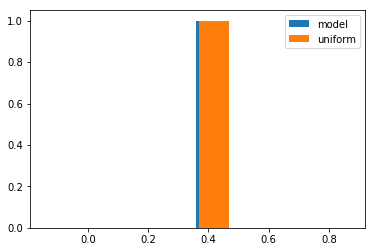

In [141]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));